In [1]:
import numpy as np
import itertools
from myo.utils import TimeInterval
import myo
import sys
import time
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import socket

In [25]:
# general stuff
classes = ['I', 'L', 'U', 'point', 'request']
FS = 200
LEN_SYMBOL = 2
LEN_PAUSE = 1
n_epochs = 5
data_dir = './data/'
subject = None
session = None
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

In [26]:
class Listener(myo.DeviceListener):

    def __init__(self, annotation='none'):
        # IMPORTANT LEAVE THIS NUMBER AS LOW AS POSSIBLE TO GUARANTEE 200 Hz in all systems
        self.interval = TimeInterval(None, 0.00000005)  
        self.orientation = None
        self.pose = myo.Pose.rest
        self.emg_enabled = True
        self.locked = False
        self.rssi = None
        self.emg = None
        self.saved_emg = []
        self.annotations = []
        self.annotation = annotation

    def output(self):
        if not self.interval.check_and_reset():
            return

        parts = []
        parts.append('E' if self.emg_enabled else ' ')
        if self.emg:
            _emg = []
            for comp in self.emg:
                parts.append(str(comp).ljust(5))
                _emg.append(comp)
            self.saved_emg.append(_emg)
            self.annotations.append(self.annotation)
        sys.stdout.flush()

    def on_connected(self, event):
        event.device.request_rssi()
        event.device.stream_emg(self.emg_enabled)

    def on_rssi(self, event):
        self.rssi = event.rssi
        self.output()

    def on_pose(self, event):
        pass

    def on_emg(self, event):
        self.emg = event.emg
        self.output()

    def on_unlocked(self, event):
        self.locked = False
        self.output()

    def on_locked(self, event):
        self.locked = True
        self.output()

In [29]:
# SUBJECT
subject = 'Gemma'
session = 1
filename = "/Users/enea/Dropbox/PhD/Projects/hand_gestures_cc19/data/" + subject + str(session)

In [30]:
if subject is None or session is None:
    raise ValueError("Select name and session for the subject!")
myo.init()
hub = myo.Hub()
listener = Listener()

ss_dvs = "startlogging {}_dvs".format(filename)
ss_davis = "startlogging {}_davis".format(filename)
# for jAER
sock.sendto(ss_davis.encode(), ("127.0.0.1", 8997))
sock.sendto(b"zerotimestamps", ("127.0.0.1", 8997))
sock.sendto(ss_dvs.encode(), ("127.0.0.1", 8998))
sock.sendto(b"zerotimestamps", ("127.0.0.1", 8998))

for e in range(n_epochs):
    for _class in classes:
        
        sys.stdout.write("\rRelax for %d seconds" % (LEN_PAUSE))
        sys.stdout.flush()
        while True:
            listener.annotation = 'none'
            if hub.run(listener.on_event, LEN_PAUSE * 1000):
                break
        sys.stdout.write("\r%s                                            " % (_class))
        sys.stdout.flush()
        while True:
            listener.annotation = _class
            if hub.run(listener.on_event, LEN_SYMBOL * 1000):
                break

sys.stdout.write("\rRelax for %d seconds" % (LEN_PAUSE))
sys.stdout.flush()
while True:
    listener.annotation = 'none'
    a = hub.run(listener.on_event, LEN_PAUSE * 1000)
    if a:
        sock.sendto(b"stoplogging", ("127.0.0.1", 8997))
        sock.sendto(b"stoplogging", ("127.0.0.1", 8998))
        break      
print("\nDone!")
SUB = subject
SES = session
subject = None
session = None

Relax for 1 seconds                                
Done!


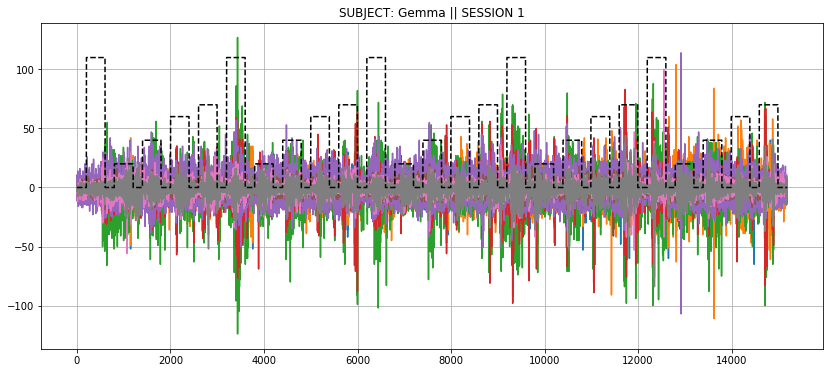

In [32]:
if len(listener.saved_emg) != len(listener.annotations):
    raise ValueError("Length of emg ({}) and annotation ({}) is different. Something is wrong!".format(len(listener.saved_emg), len(listener.annotations)))

EMG = np.array(listener.saved_emg)
ANN = np.array(listener.annotations)
name_dict = {'I':110, 'L':20,'U':40, 'point': 60, 'request': 70, 'none':0}

plt.figure(figsize=(14,6))
plt.plot(EMG)
plt.grid()
plt.title("SUBJECT: {} || SESSION {}".format(SUB, SES))
_ = plt.plot([name_dict[i] for i in ANN], 'k--')


In [33]:
# double check length
trials = []
for _class in classes:
    _annotation = np.float32(ANN == _class)
    derivative = np.diff(_annotation)/1.0
    begins = np.where(derivative == 1)[0]
    ends = np.where(derivative == -1)[0]
    for b, e in zip(begins, ends): 
        trials.append(EMG[b:e])
print("AVG length: {} (should be 400)".format(np.mean([len(a) for a in trials])))

AVG length: 399.2 (should be 400)


In [34]:
# save it! 
np.save(data_dir + 'training_{}{}_2s_26_11_emg'.format(SUB, SES), EMG)
np.save(data_dir + 'training_{}{}_2s_26_11_ann'.format(SUB, SES), ANN)

In [ ]:
EMG = np.load('./data_Fusi/training_Melika_1s_emg.npy')
ANN = np.load('./data_Fusi/training_Elisa_1s_ann.npy')